# Задание 2


Умножение столбца на столбец осуществляется сразу на всех ядрах в одну итерацию. В идеальном случае задержки на связь отсутствуют, поэтому имеем:
$$
S_p = p \\
E_p = 1
$$

Этот же результат можно получить как частный случай оценки сложности умножения матрицы на вектор (см. [здесь](https://www.intuit.ru/studies/courses/1156/190/lecture/4952?page=2)).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
df_all = pd.read_csv('results.csv', sep=';')
df_all.head()

,n,p,time
0,1000000,2,0.544933
1,2000000,2,1.116346
2,3000000,2,1.562413
3,4000000,2,2.133739
4,5000000,2,2.573424


In [30]:
df_all.p -= 1

In [31]:
#df_all.p = df_all.p.max() - df_all.p

## Ускорение и закон Амдаля

In [32]:
for n in df_all.n.unique():
    for p in df_all.p.unique():
        df_all.loc[(df_all.p==p)&(df_all.n==n),'mean_time'] = df_all[(df_all.p==p)&(df_all.n==n)]['time'].mean()

In [33]:
df = df_all
df

,n,p,time,mean_time
0,1000000,1,0.544933,0.544933
1,2000000,1,1.116346,1.116346
2,3000000,1,1.562413,1.562413
3,4000000,1,2.133739,2.133739
4,5000000,1,2.573424,2.573424
5,6000000,1,3.148605,3.148605
6,7000000,1,4.447984,4.447984
7,1000000,2,0.336020,0.336020
8,2000000,2,0.708805,0.708805
9,3000000,2,0.898307,0.898307


In [34]:
for n in df.n.unique():
    for p in df.p.unique():
        p_1_time = (df[(df.n==n)&(df.p==1)]['mean_time']).iloc[0]
        own_time = df[(df.p==p)&(df.n==n)]['mean_time'].iloc[0]
        df.loc[(df.p==p)&(df.n==n),'accel'] = p_1_time/own_time

In [35]:
df['eff'] = df['accel']/df['p']

## Аппроксимации ускорений

In [36]:
def amdal(p, f):
    return 1/(f + (1-f)/p)
def gustav(p, s):
    return p + (1-p)*s

In [37]:
def plot_save_graphs(x_label, y_label, fixed='p'):
    
    def _appr_accel(n, p):
        # TODO: place here theoretical approximation
        #return 6*n/(6*n/p + 6 + np.log2(p))
        return n/n*p
    
    def _appr_eff(n, p):
        return _appr_accel(n, p)/p
    
    def _appr_gustav(n, p, accels):
        '''
        if len(np.array(o).reshape(-1)) == 1:
            n = np.array([n]*len(accels))
        elif len(np.array(accels).reshape(-1)) == 1:
            accels = np.array([accels]*len(n))
        '''
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(gustav, p, accels)
        return gustav(p, popt[0])*p/p# - 2
    
    def _appr_amdal(n, p, accels):
        if len(np.array(p).reshape(-1)) == 1:
            p = np.array([p]*len(accels))
        elif len(np.array(accels).reshape(-1)) == 1:
            accels = np.array([accels]*len(p))
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(amdal, p, accels)
        return amdal(p, popt[0])
    

    def get_gustav_data(data):
        min_p, min_n = min(data['p']), min(data['n'])
        koeff = min_n/min_p
        indices = np.equal(data['n']/data['p'], koeff)
        x_data, y_data = data['p'][indices], data['accel'][indices]
        return x_data, y_data
    
    def _routine(data, x_label, y_label, fixed_value, full_data=None):
        x_data, y_data = data[x_label], data[y_label]
        
        plt.scatter(x_data, y_data, label='real')
        p, n = (fixed_value, x_data)
        if x_label == 'p':
            p, n = (n, p)
        # Approximation
        if y_label == 'accel':
            plt.scatter(x_data, _appr_accel(n, p), color='red', label='theor')
            if x_label == 'p':
                plt.scatter(x_data, _appr_amdal(n, p, y_data), color='green', label='amdal')
                if full_data is not None:
                    gustav_x_data, gustav_y_data = get_gustav_data(full_data)
                    #print(gustav_x_data, '\n', gustav_y_data)
                    plt.scatter(gustav_x_data, _appr_gustav(n, gustav_x_data, gustav_y_data), color='grey', label='gustav')
                    #plt.scatter(gustav_x_data, gustav_y_data, color='grey', label='gustav')
            #else:
            #    plt.scatter(x_data, _appr_gustav(n, p, y_data), color='grey', label='gustav')
        elif y_label == 'eff':
            plt.scatter(x_data, _appr_eff(n, p), color='red', label='theor')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.title(f'{y_label}, {fixed}={fixed_value}')
        plt.savefig(f'{y_label}_{fixed}_{fixed_value}', dpi=120)
        plt.show()
    if fixed == 'n':
        for n in df.n.unique():
            data = df[df.n==n]
            _routine(data, x_label, y_label, n, full_data=df)
    elif fixed == 'p':
        for p in df.p.unique():
            data = df[df.p==p]
            _routine(data, x_label, y_label, p)
    else:
        raise ValueError('Not implemented')

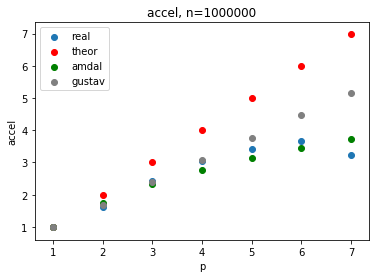

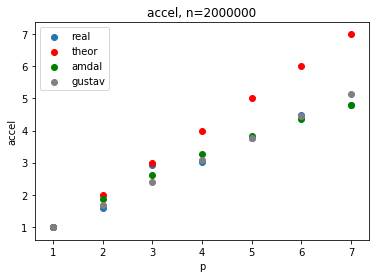

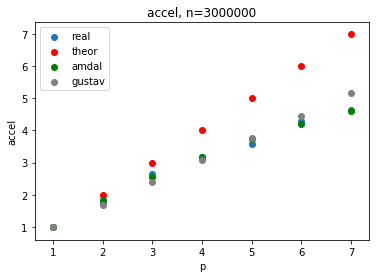

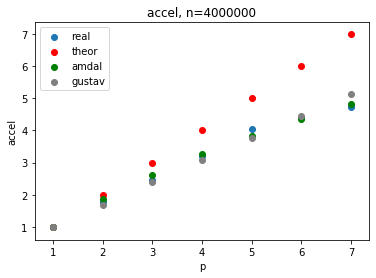

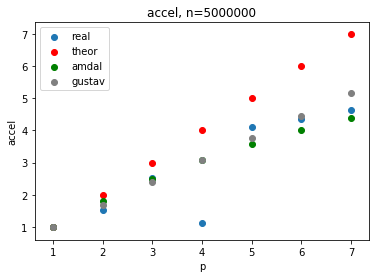

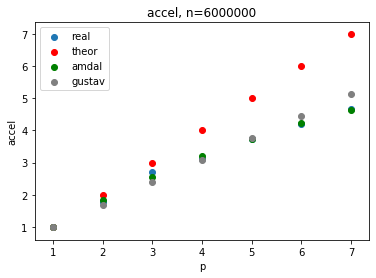

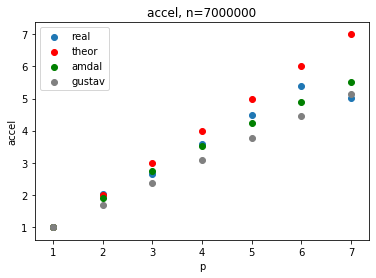

In [39]:
plot_save_graphs('p', 'accel', fixed='n')
#plot_save_graphs('n', 'accel', fixed='p')
#plot_save_graphs('p', 'eff', fixed='n')
#plot_save_graphs('n', 'eff', fixed='p')